### <center>House Price Prediction</center>
### <center>Michael Moore</center>

### 1. Introduction
The process of valuing and marketing a house is challenging. Traditional methods used by realtors only consider a limited number of parameters over a relatively small sample size, which can lead to houses being misvalued. There is also the potential for realtors to have an unconscious bias when valuing a property, which can be detrimental to prospective buyers. These shortcomings of traditional valuing techniques have presented the need for more advanced, accurate, and efficient methods of valuing a house. The purpose of this project is to take part in the House Prices- Advanced Regression Techniques competition. This competition involves the analysis of 79 different variables describing numerous aspects of houses in Ames, Iowa, and subsequently developing machine-learning models capable of predicting the final prices. This notebook will provide a detailed analysis of the data and the experimentation of three different machine-learning models, namely Linear, Ridge and Lasso Regression to investigate their prediction accuracy. The effect of various parameters on each model's accuracy will be conducted, and different machine-learning tuning methods will be explored.

### 2. Data Exploration

#### Import Libraries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from scipy import stats
from sklearn.model_selection import GridSearchCV, learning_curve, KFold, train_test_split, cross_val_score
from scipy.stats import skew
from sklearn.svm import SVR
import warnings 

#### Load the Datasets

Both the dataset used for training and the dataset used for testing have been loaded in below. These two datasets have been joined for the purposes of data exploration and data cleaning; however, they will be seperated before training the models.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
iowa_houses_df = pd.concat([train,test], axis = 0)
print("The size of the combined training and testing dataset is: " + str(iowa_houses_df.shape))
iowa_houses_df.head()

The size of the combined training and testing dataset is: (2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


To get a better understanding of the data, information related to the data types, missing values and variable names has been presented below. This information shows that this dataset is made up of both numerical and categorical data and that specific variables are missing a large amount of data.

In [3]:
iowa_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

#### Target Variable

In this project, the variable that needs to be predicted is the "SalePrice", while the other variables are the features used for the prediction. The distribution of the house prices has been plotted below and it is clear that the data is positively skewed. Skewness is a measurement of asymmetry in a dataset and is measured with respect to the normal distribution, which is perfectly symmetric about the mean. The main challenge presented by skewed data is that there are a greater number of outliers represented by the tail of the distribution. When training regression models on skewed data, the outliers can significantly reduce the models accuracy and thus it is important to correct this skewness.  

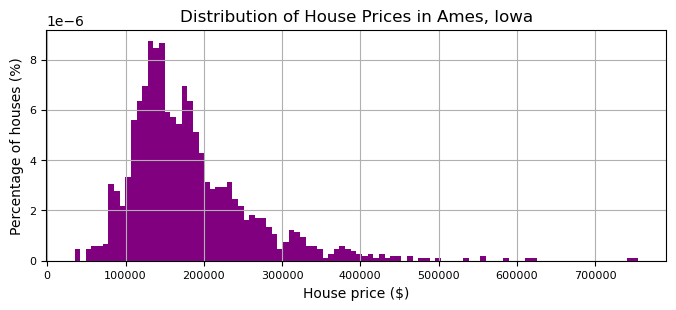

In [4]:
Features = iowa_houses_df.drop(['SalePrice','Id'], axis=1)
Target = train[['SalePrice']]
Target.hist(figsize=(8, 3),bins = 100, xlabelsize=8, ylabelsize=8, color='purple', density = True);
plt.title("Distribution of House Prices in Ames, Iowa");
plt.ylabel('Percentage of houses (%)');
plt.xlabel('House price ($)');

From analysing the distribution of the house prices above, it can be concluded that the data follows a log-normal distribution. This characteristic means that the skewness of the data can be reduced and an approximate normal distribution can be achieved by taking the log transform of the house price data. The code below performs this transformation and the log-normalised data can be seen in the generated plot. 

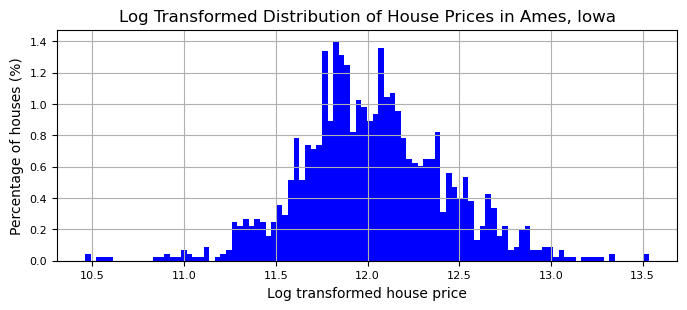

In [5]:
Target = np.log1p(train["SalePrice"])
Target = pd.DataFrame(Target, columns=["SalePrice"])
Target.hist(figsize=(8, 3),bins = 100, xlabelsize=8, ylabelsize=8, color='blue', density = True);
plt.title("Log Transformed Distribution of House Prices in Ames, Iowa");
plt.ylabel('Percentage of houses (%)');
plt.xlabel('Log transformed house price');

#### Feature Variables

The feature variables are the house characteristics that will be used to predict the price. As discovered while analysing the dataset's information, both numerical and categorical variables are present. It is important to seperate these two data types because the analysis and data cleaning differs between them. The code below seperates the numerical and categorical variables and saves them as two seperate datasets. The code also converts the "MSSubClass" variable into a string and stores it in the categorical dataset. This variable originally consisted of integer values; however, they served no purpose other than category names. 

In [6]:
categorical_data = []
categorical_data.extend(list(Features.dtypes[Features.dtypes == object].index))
categorical_data_df = pd.DataFrame(Features, columns=categorical_data)
categorical_data_df['MSSubClass'] = Features['MSSubClass']
categorical_data_df['MSSubClass'] = categorical_data_df['MSSubClass'].apply(str)
print("Categorical data:")
display(categorical_data_df.head())

numeric_data = []
numeric_data.extend(list(Features.dtypes[Features.dtypes == np.int64].index))
numeric_data.extend(list(Features.dtypes[Features.dtypes == np.float64].index))
numeric_data_df = pd.DataFrame(Features, columns=numeric_data)
numeric_data_df = numeric_data_df.drop(['MSSubClass'], axis=1)
numeric_data.remove('MSSubClass')
print("Numerical data:")
display(numeric_data_df.head())

Categorical data:


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,70
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60


Numerical data:


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,...,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,8450,7,5,2003,2003,856,854,0,1710,2,...,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
1,9600,6,8,1976,1976,1262,0,0,1262,2,...,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
2,11250,7,5,2001,2002,920,866,0,1786,2,...,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
3,9550,7,5,1915,1970,961,756,0,1717,1,...,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
4,14260,8,5,2000,2000,1145,1053,0,2198,2,...,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0


#### Distrubution of Numerical Features

The distributions of each of the numerical features is presented below. It is evident that many of the features are skewed which needs to be corrected for the reasons stated previously. 

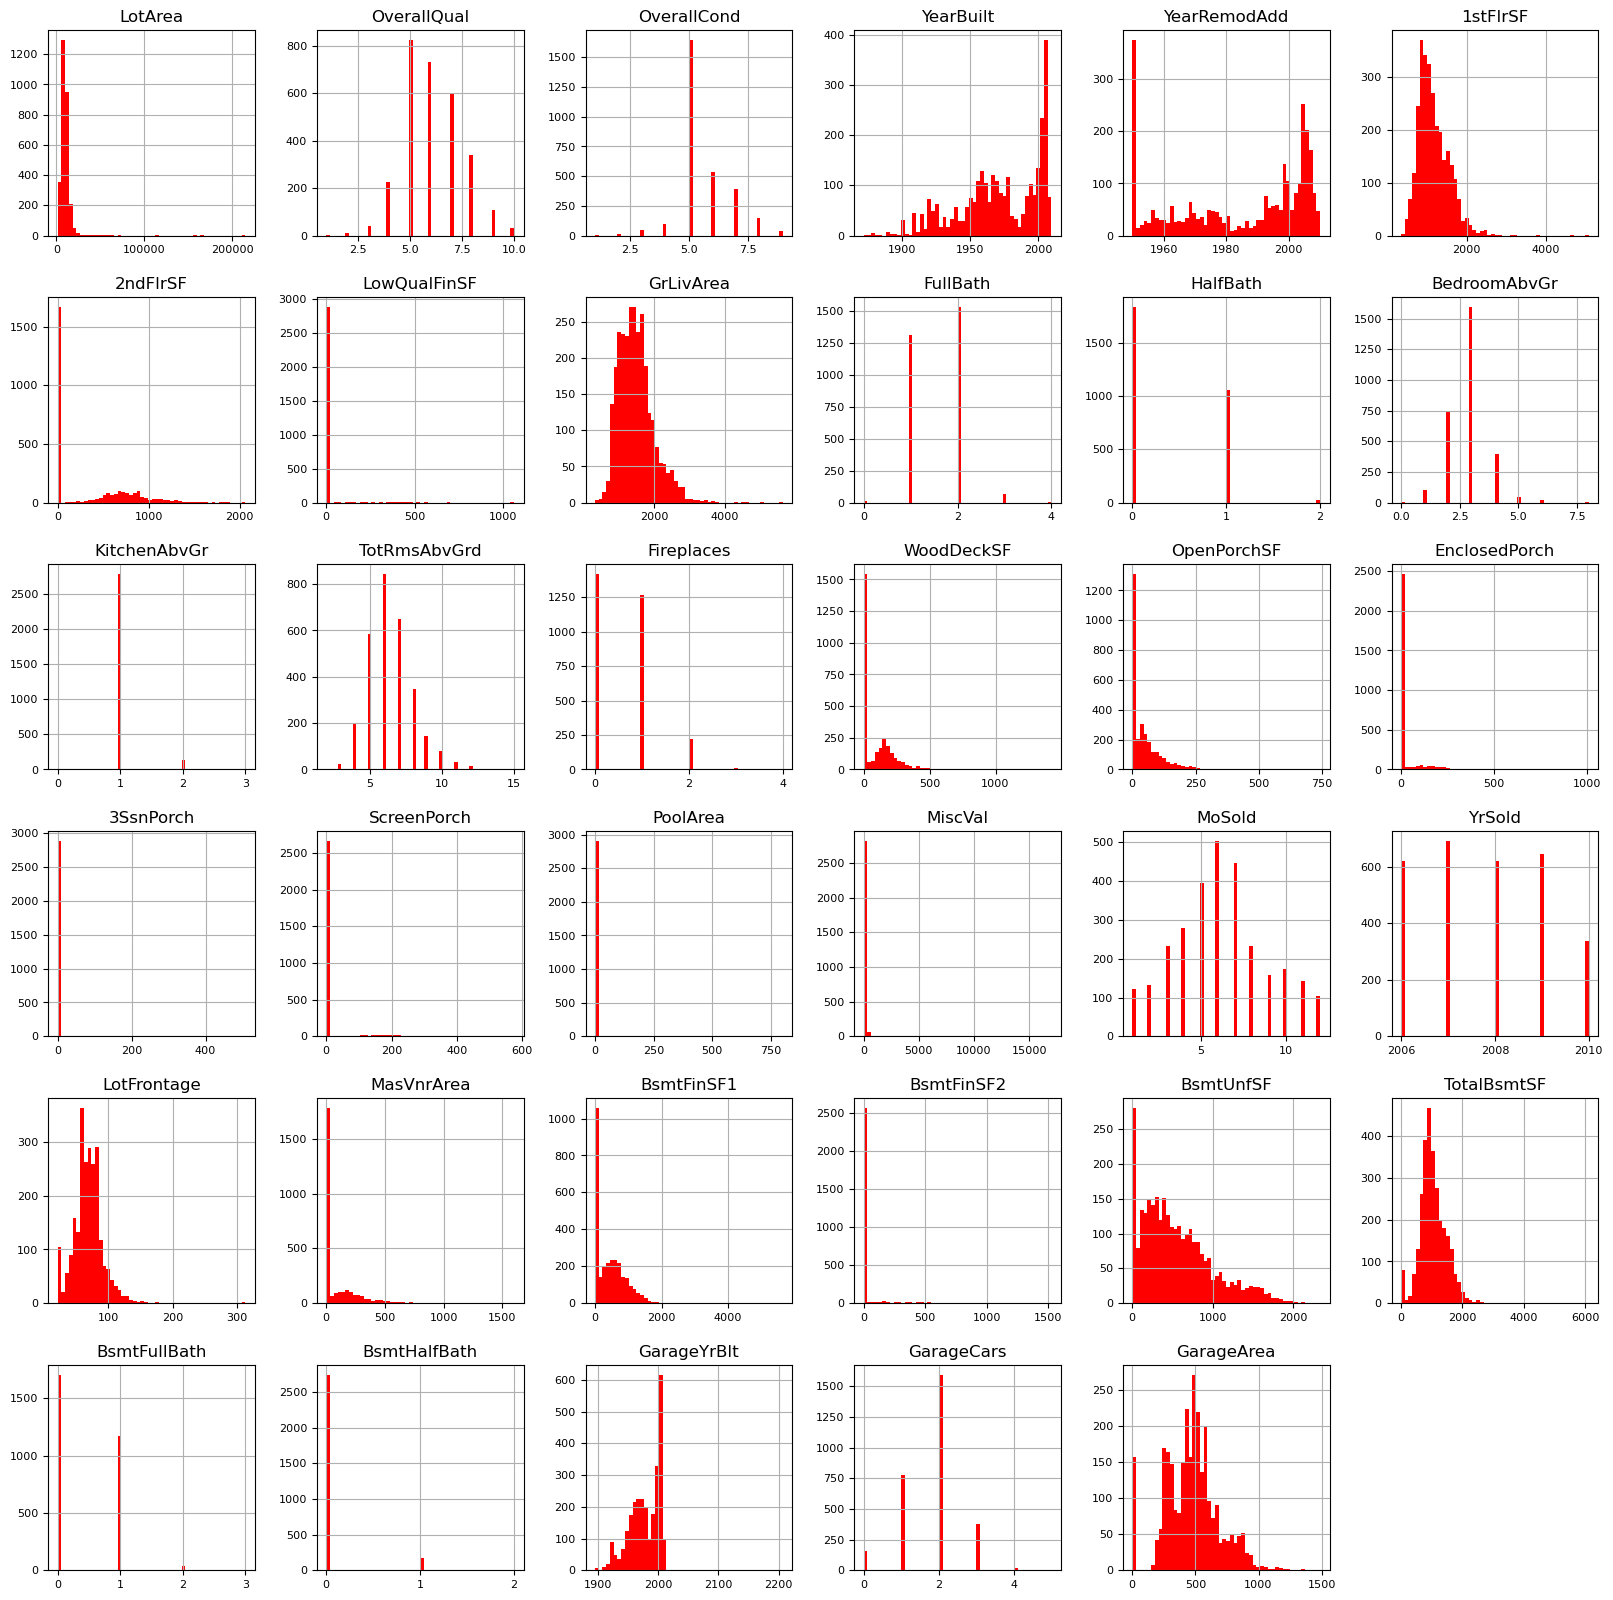

In [7]:
numeric_data_df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8, color = "Red");

Before the data can be transformed, the features that are signifcantly skewed must be identified. Positive skewness is defined as data that has a skewness score between 0.5 and 1, thus a threshold of 0.75 has been set. All the features that are identified as skewed are subsequently log transformed and the the resulting distributions have been presented. 

In [8]:
skewed_features = numeric_data_df[numeric_data].apply(lambda x: skew(x.dropna())) 
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index
numeric_data_df[skewed_features] = np.log1p(numeric_data_df[skewed_features])

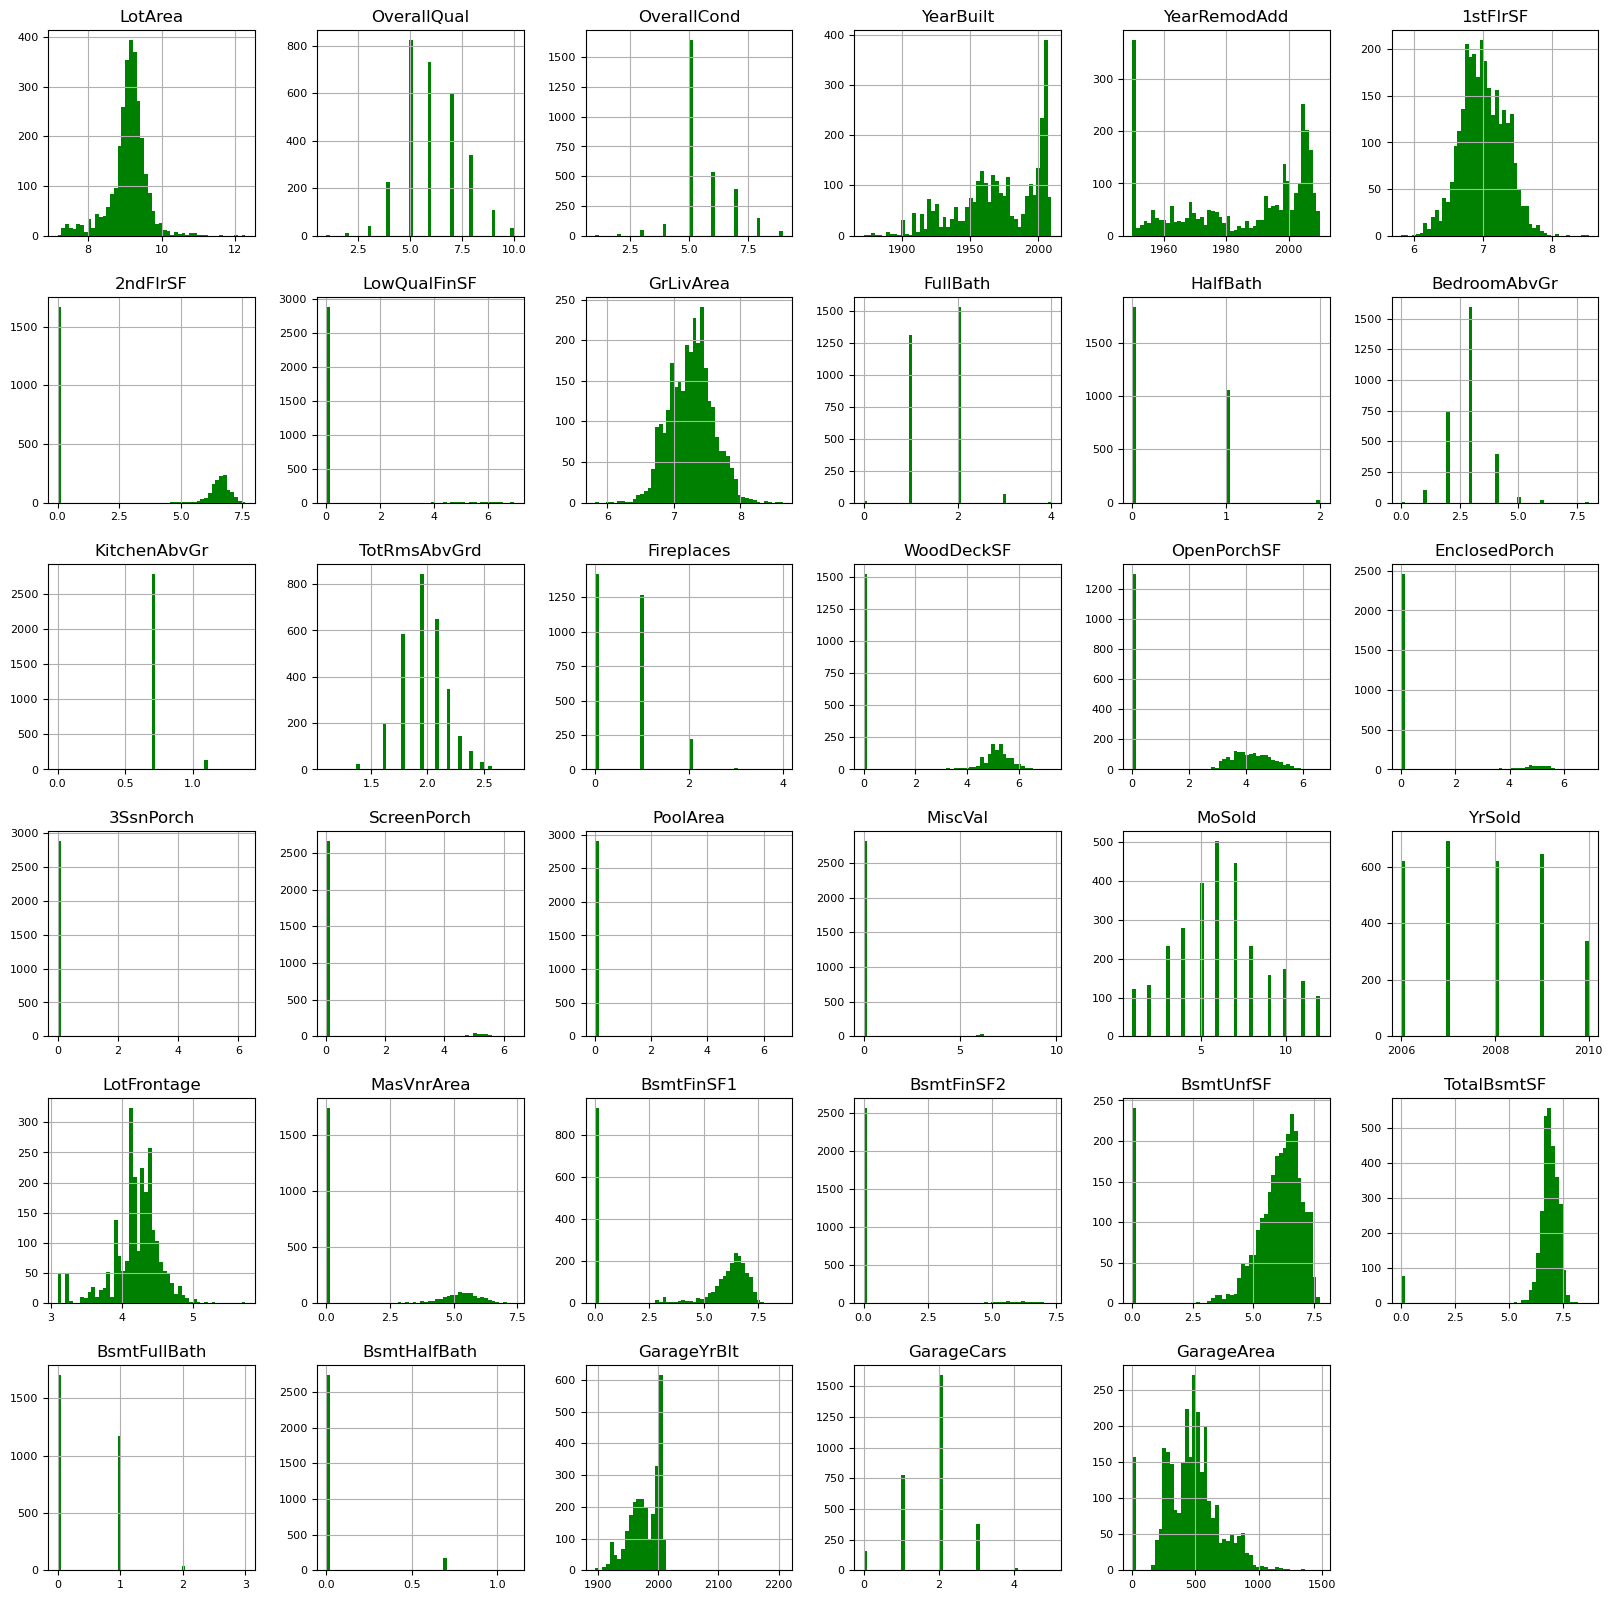

In [9]:
numeric_data_df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8, color = "Green");

#### Visualisation of Categorical Data

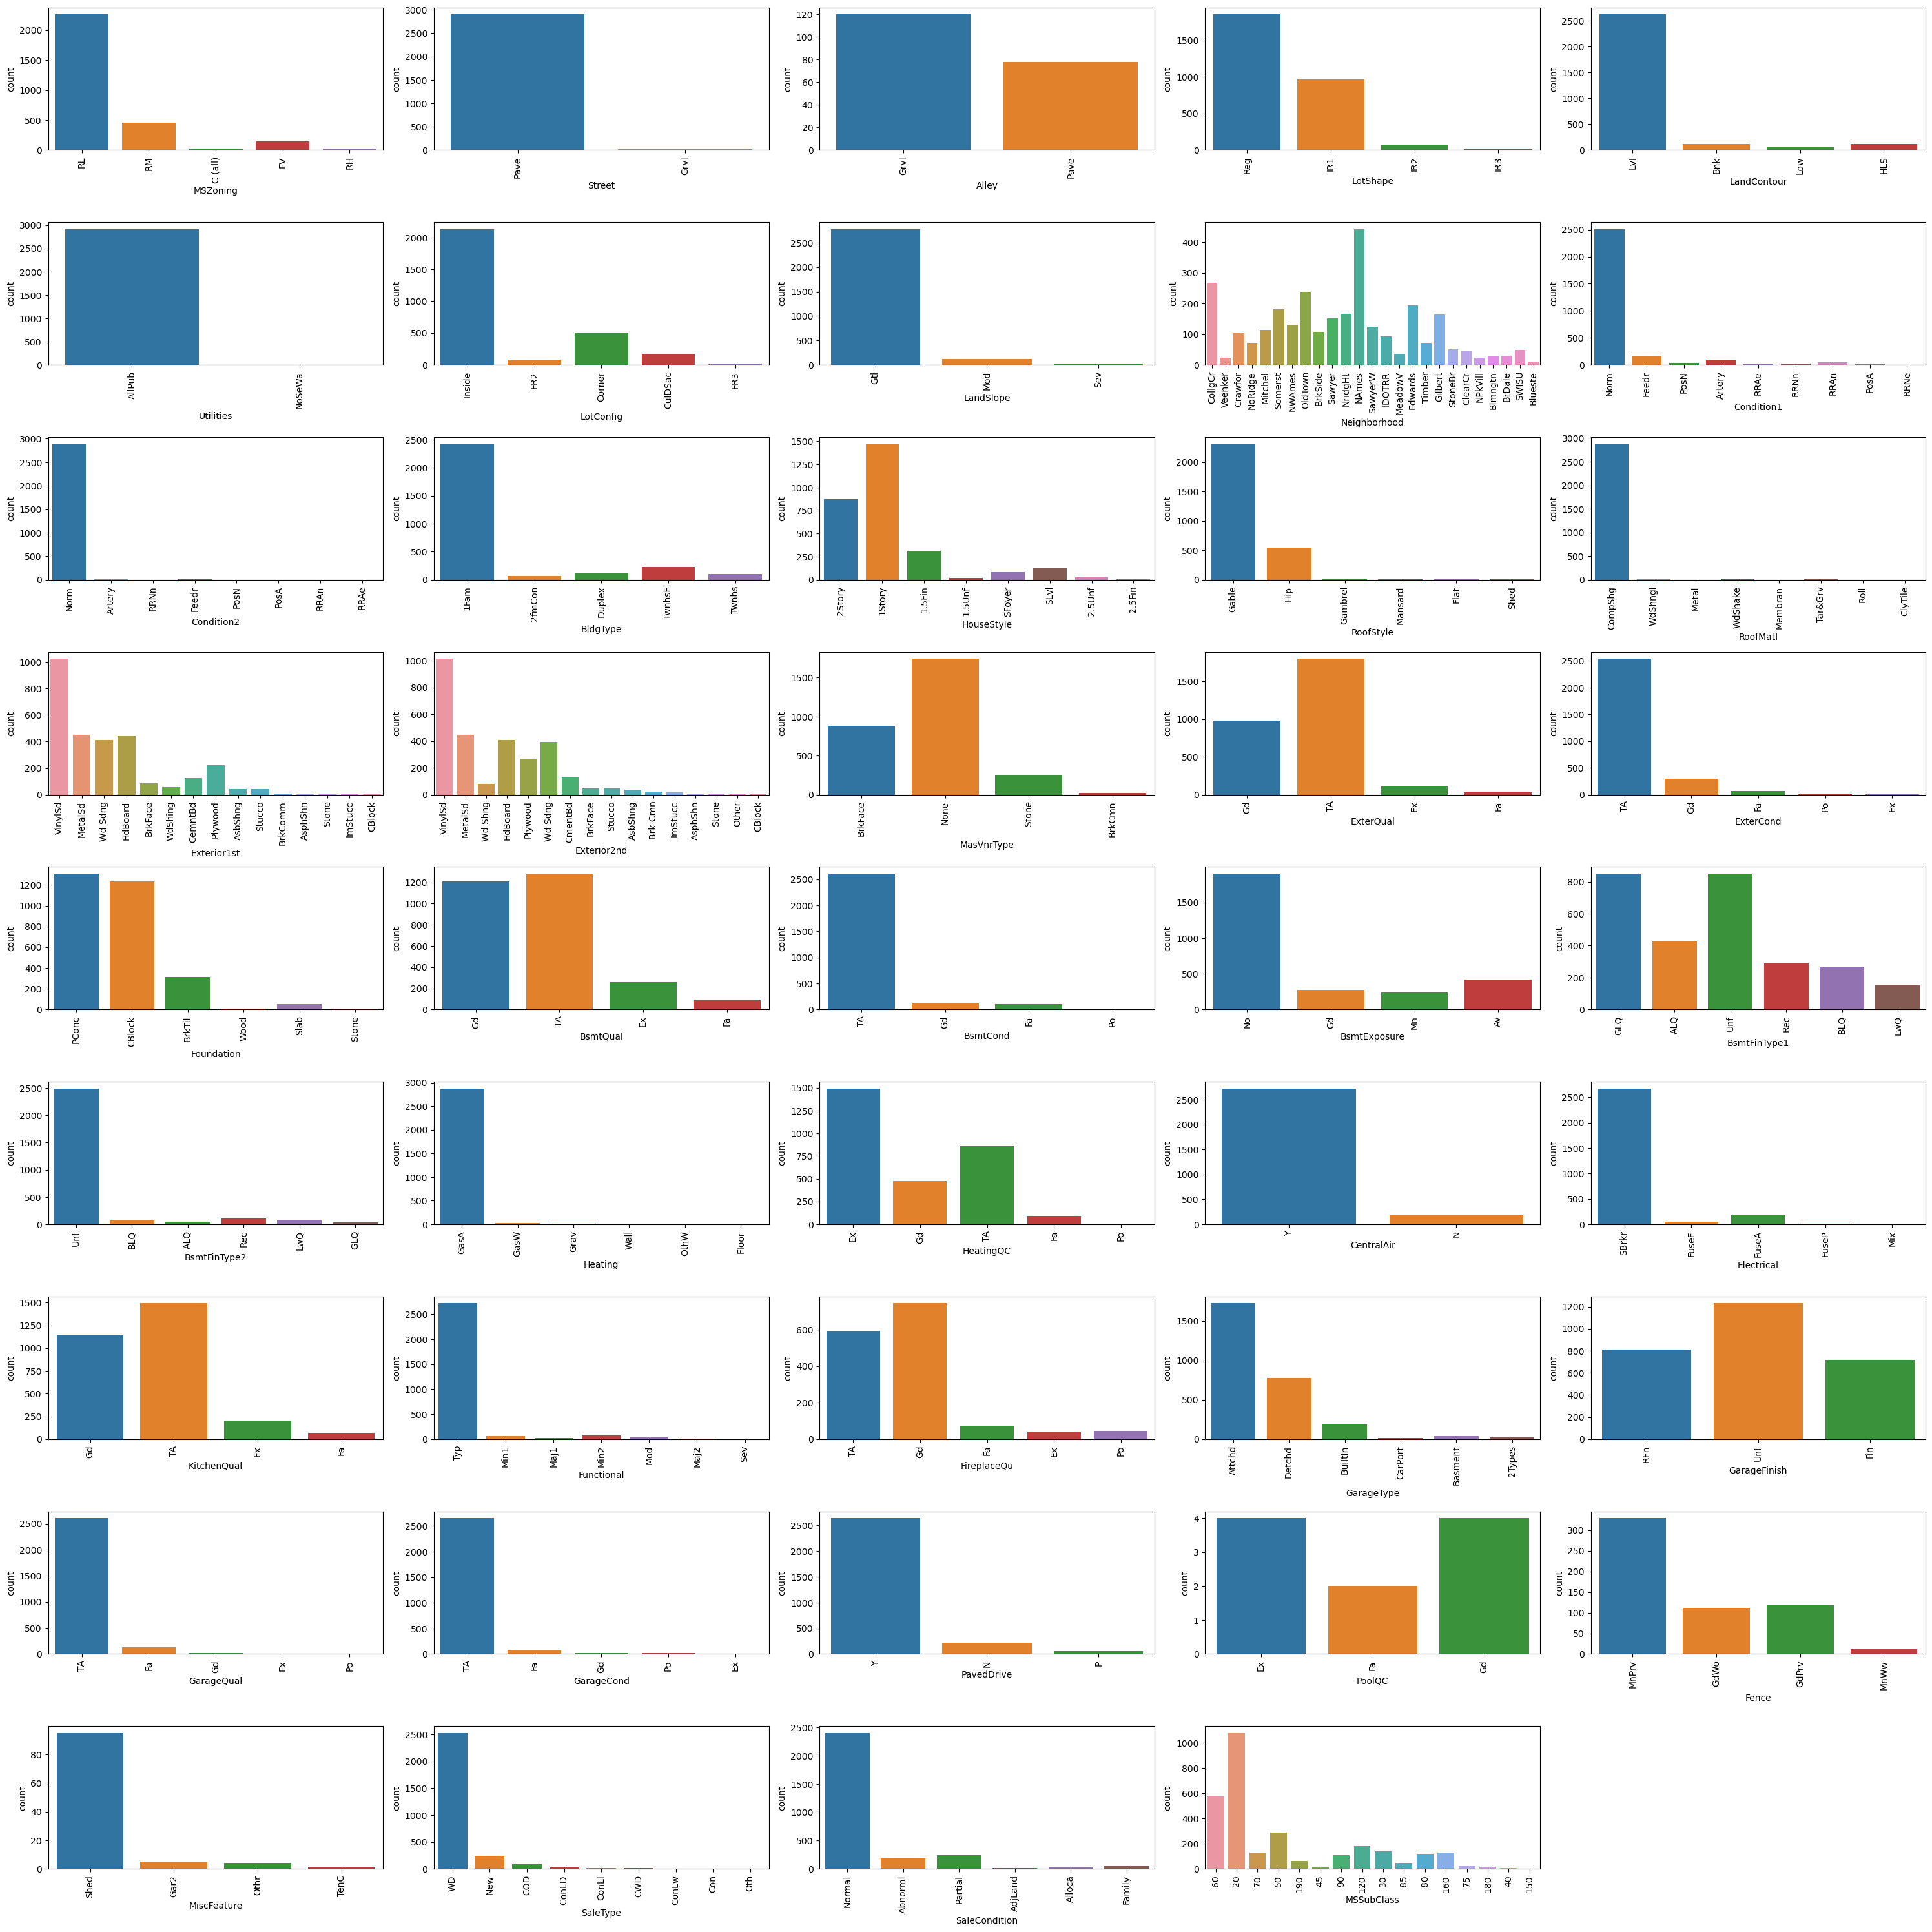

In [10]:
fig = plt.figure(figsize=(30,30))
for k in range(len(categorical_data_df.columns)):
    plt.subplot(9,5,k+1)
    sns.countplot(x=categorical_data_df.iloc[:,k], data=categorical_data_df.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

From the analysis of the categorical data above, it can be seen that some of the features, such as the street type, utilities, roof material and heating are the same for the majority of houses in the dataset. Due to these features being mostly constant, they are not a meaningful metric to distingush between houses and thus their effect on the prediction of the house price might be low. Due to this reason, these features will be removed from the dataset, thus reducing the the computational complexity.

In [11]:
categorical_data_df = categorical_data_df.drop(["Street","Utilities","RoofMatl","Condition2","Heating"],axis=1)

#### Correlation Between Numerical Features and the SalePrice

The correlation between two variables is the measure of the linear relationship. A correlation coefficient of 1 represents a perfectly positive linear relationship, 0 represents no linear relationship and -1 represents a perfectly negative linear relationship. While a high correlation does not necessarily indicate causation, it provides useful insight into the relationships within the data.

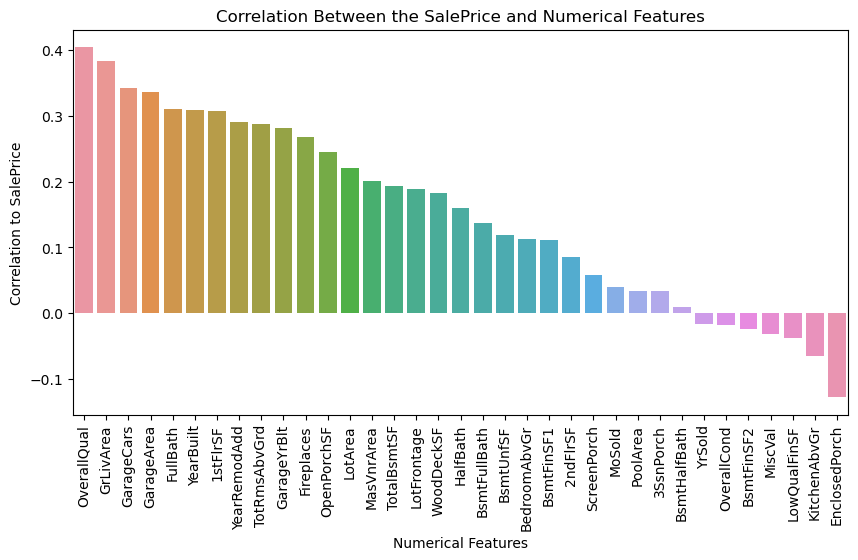

In [12]:
fig = plt.figure(figsize=(10,5))
numeric_corr = pd.concat([numeric_data_df, Target], axis=1)
correlation = numeric_corr.corr()
corr_with_target = correlation['SalePrice'].sort_values(ascending=False)[1:]
sns.barplot(x=corr_with_target.index, y=corr_with_target)
plt.xticks(rotation=90)
plt.xlabel("Numerical Features")
plt.ylabel("Correlation to SalePrice")
plt.title("Correlation Between the SalePrice and Numerical Features")
plt.show()

The heatmap generated below, shows the correlation that exists between the different numerical features. It can be concluded from this heatmap that there are several pairs of variables that are highly correlated which is known as multicollinearity. 

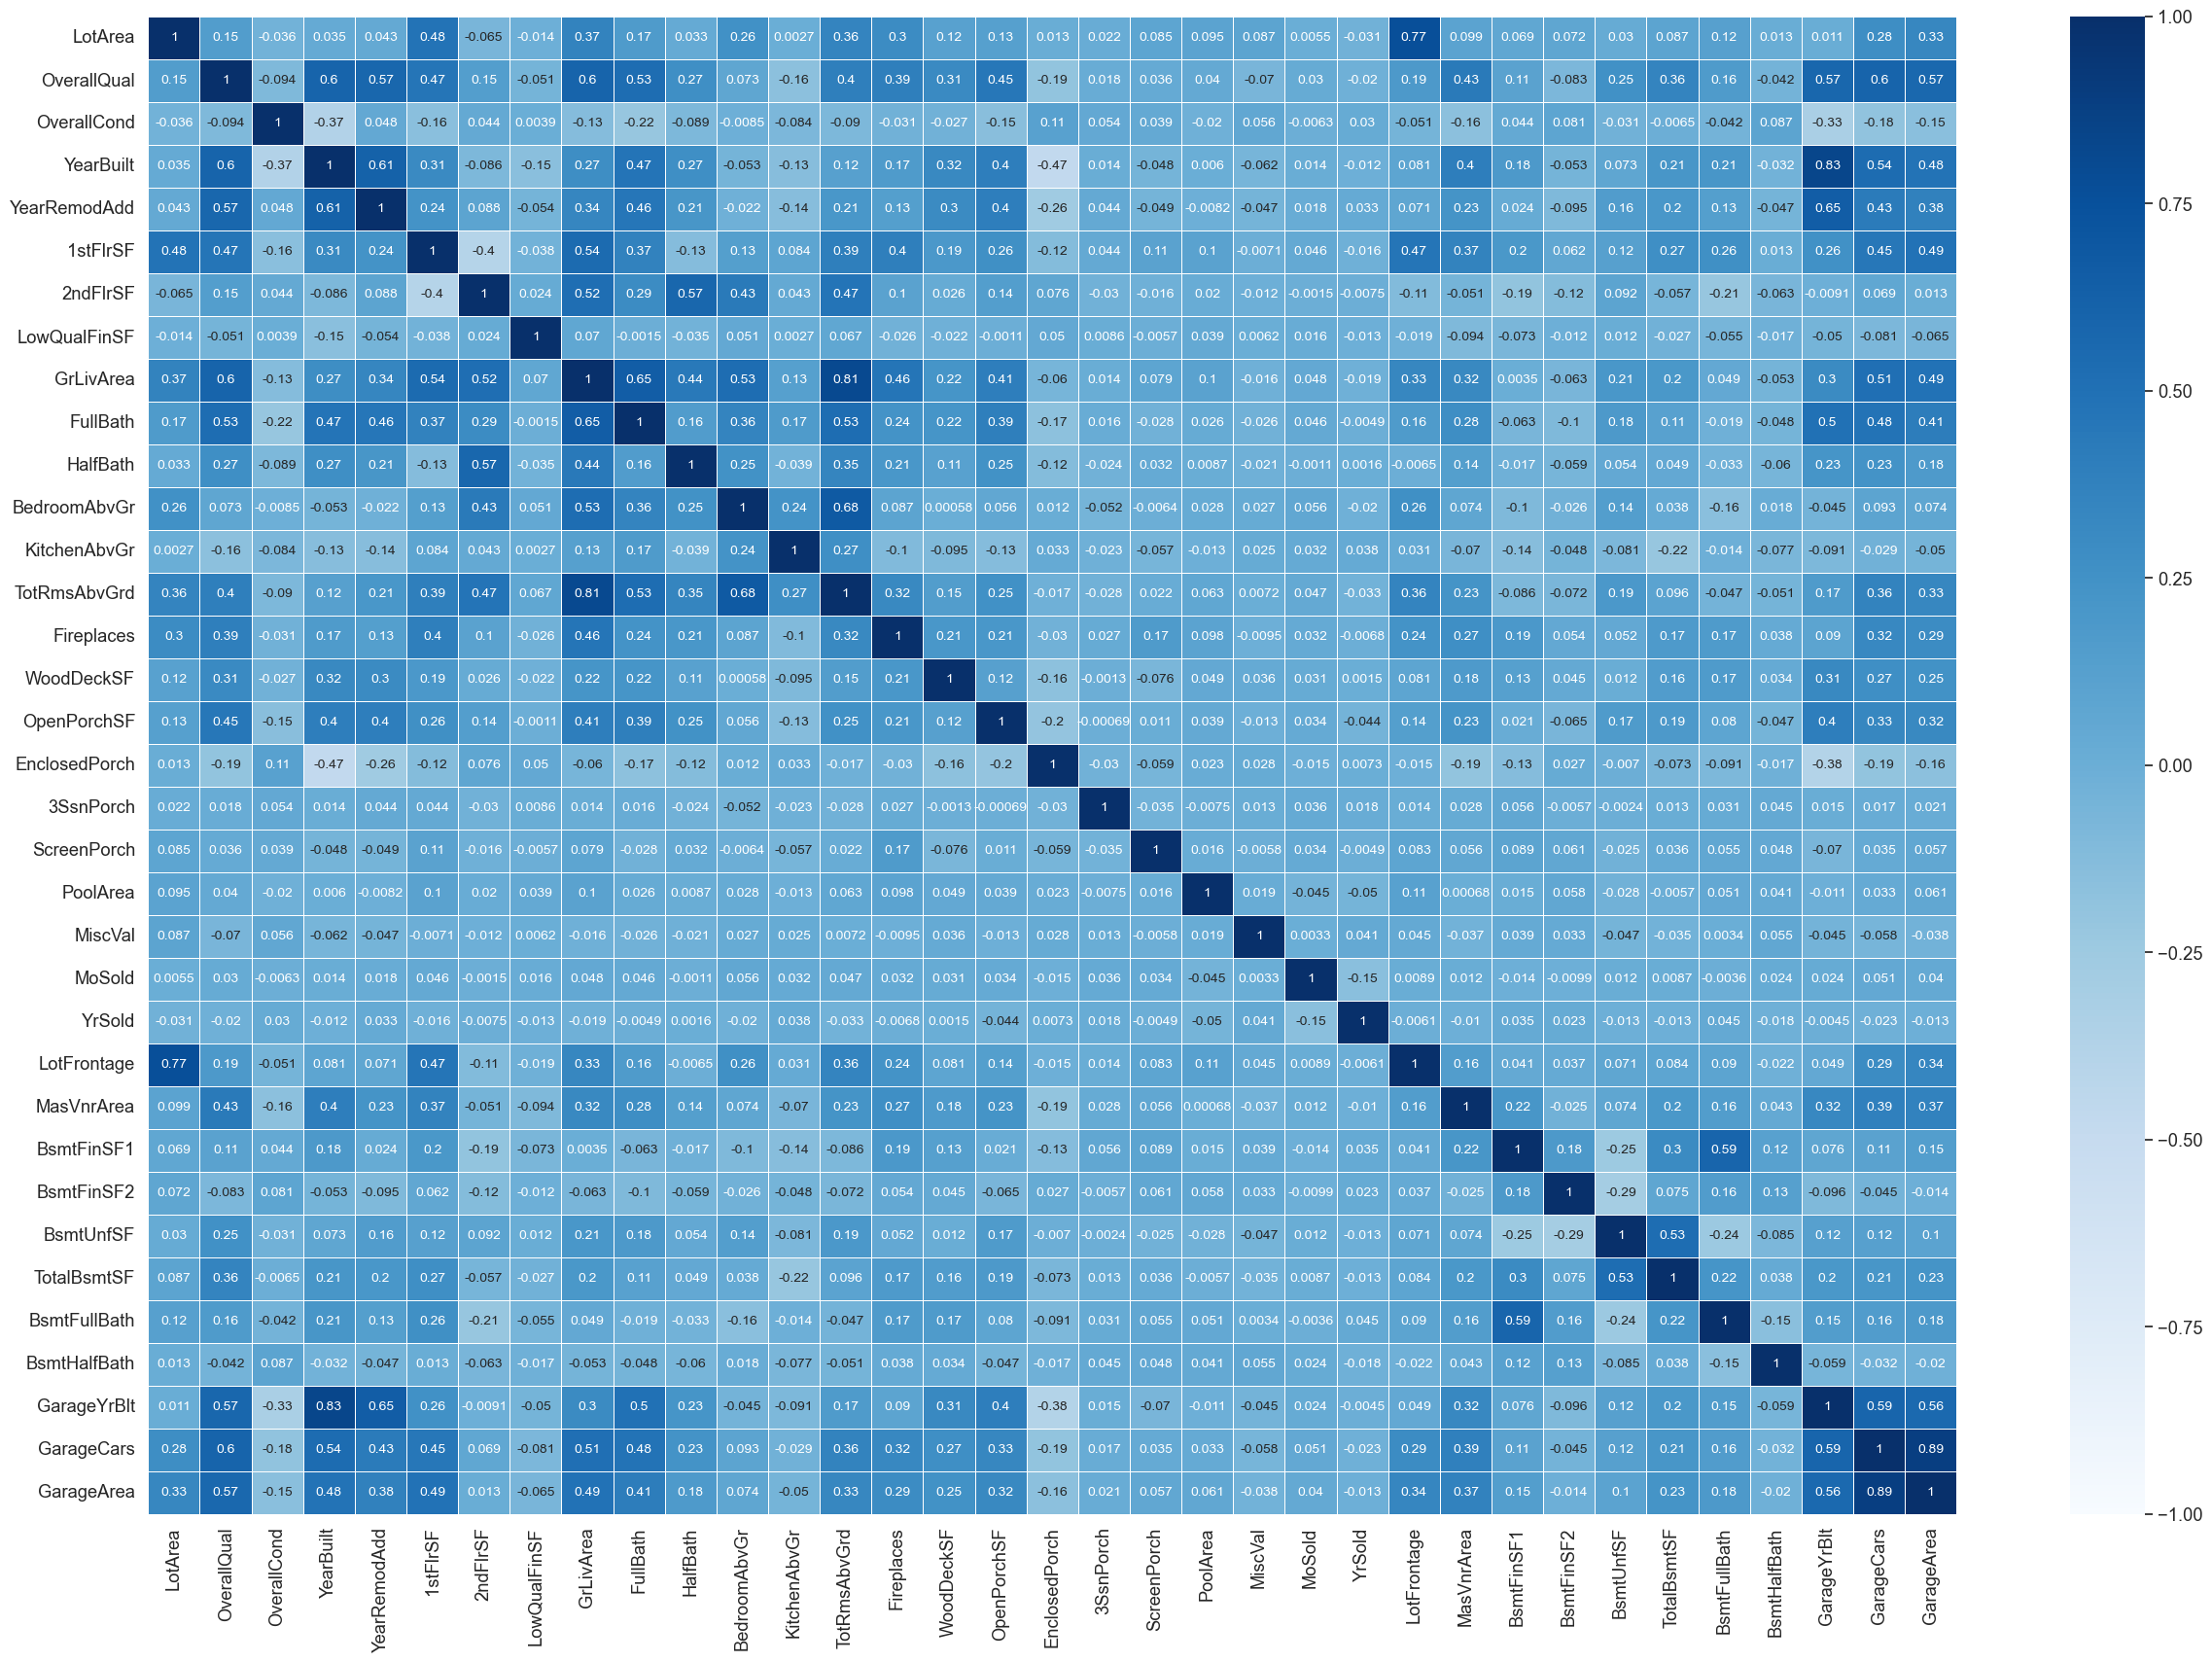

In [13]:
fig = plt.figure(figsize=(30,20))
sns.set(font_scale=1.2)
corr_arr = numeric_data_df.corr()
sns.heatmap(corr_arr, vmin=-1,vmax=1,mask = corr_arr <-1,linewidths = 0.5,cmap=plt.cm.Blues,annot=True,annot_kws={'fontsize':10});

#### Data Imputation

The dataset contains variables that are missing values. Before a model can be trained on the data, these missing values must be corrected. The code below fills in missing numerical data by calculating and imputing the mean of each variable. A similar process is performed on the categorical data; however, the mode of each variable is used instead.

In [14]:
def find_mode(dataframe):
    for column in dataframe.columns:
        mode = dataframe[column].mode()[0]
        dataframe[column] = dataframe[column].fillna(mode)
    return dataframe

categorical_data_df = find_mode(categorical_data_df)
numeric_data_df = numeric_data_df.fillna(numeric_data_df.mean())

#### Data Encoding

Models can only be trained on numerical values and thus the categorical data has to be encoded. The code below performs dummy encoding whereby each category of a variable is transformed into a binary digit. This type of encoding increases the number of features in the dataset significantly.

In [15]:
Combined_df = pd.concat([numeric_data_df, categorical_data_df], axis=1)
Combined_df = pd.get_dummies(Combined_df)
print("The size of the final dataset is: " + str(Combined_df.shape))

The size of the final dataset is: (2919, 277)


### 3. Experimentation

For the experimentation, three different regression models have been selected, which are Linear Regression, Ridge Regression and Lasso Regression. Ridge and Lasso regression have been chosen because they are well suited to dealing with datasets with high multicolinearity, which is present within this dataset as concluded previously. Experiments will be conducted to determine the optimal number of features to use and to determine the best hyperparameters to train these models.

#### Data Splitting

The dataset has been split into training, validation and testing data below. The training and validation datasets will be used to create and test the regression models, whereas the test dataset will be used for the final competition prediction.

In [16]:
X = Combined_df.iloc[:1460,:]
test = Combined_df.iloc[1460:,:]
t = Target
X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.3, random_state=1)

#### Feature Experimentation

The dataset used to train the models consists of 277 different features. These features have varying levels of importance when developing a model and are assigned a specific weighting to reflect this importance. The experiment below determines the importance of each feature and arranges the them in order from most significant to least significant. A regression model is then trained and validated using a set number of these features and the root mean squared error (RMSE) of the prediction is calculated. The number of features used starts at the top five most significant and increases in increments of 16 features until all features are used. This experiment has been conducted on Linear regression, Ridge regression and Lasso regression models. The results of the experiment have been presented in the graph below.     

In [17]:
def feature_RMSE(X_train,t_train, X_val,t_val,ModelType,ModelName):
    RMSE_data = []
    X_train_reset = X_train
    X_val_reset = X_val
    for i in range (5,277,16):
        warnings.filterwarnings('ignore')
        X_train = X_train_reset
        X_val = X_val_reset
        selector = SelectKBest(score_func=f_regression, k=i)
        X_train_new = selector.fit_transform(X_train, t_train.values.ravel())
        warnings.filterwarnings('ignore')
        X_test_new = selector.transform(X_val)
        warnings.filterwarnings('ignore')
        selected_features_indices = selector.get_support(indices=True)
        selected_feature_names = X_train.columns[selected_features_indices] 
        X_train = X_train[selected_feature_names]
        X_val = X_val[selected_feature_names]
        regression_model = ModelType.fit(X_train,t_train)
        predicted_price = regression_model.predict(X_val)
        MSE = mean_squared_error(t_val, predicted_price)
        RMSE = np.sqrt(MSE)
        RMSE_data = np.append(RMSE_data,RMSE)
    x = range(5,277,16)
        
    plt.plot(x, RMSE_data, label = ModelName)
    plt.xlim([5, 277])
    plt.title('Number of Features Used vs RMSE of Prediction')
    plt.xlabel('Number of features')
    plt.ylabel('RMSE of prediction')
    plt.legend()
    warnings.filterwarnings('ignore')
    return 

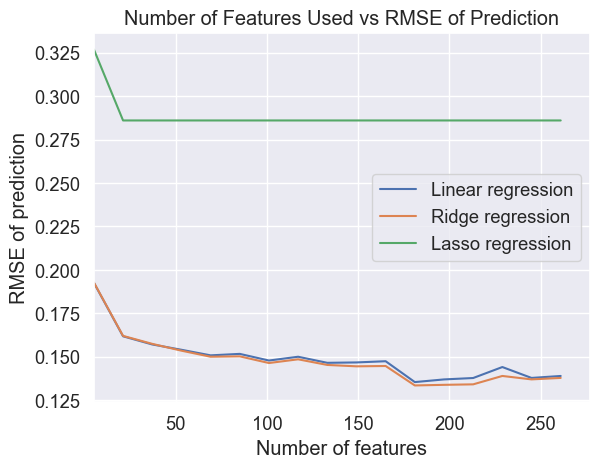

In [18]:
feature_RMSE(X_train,t_train,X_val,t_val,LinearRegression(),"Linear regression")
feature_RMSE(X_train,t_train,X_val,t_val,Ridge(),"Ridge regression")
feature_RMSE(X_train,t_train,X_val,t_val,Lasso(),"Lasso regression")

From the analysis of the graph above, it can be concluded that increasing the number of features used reduces the RMSE of the prediction for each model until a plateau is reached. It is also evident from the above graph that only using the most important features significantly reduces the performance. After analysing the results of this data, it has been concluded that all 277 features originally present in the dataset will be used to train the models because using less does not provide a significant improvement to the accuracy.

#### Hyperparameter Experimentation

Hyperparameters are parameters used to configure a model and allow for greater control over the learning process. These hyperparameters vary for different models and have optimal values based on the dataset being used for training.
For Linear regression, the hyperparameter being tested is the "fit intercept" hyperparameter. When the hyperparameter is set to True (default), the Linear regression model will estimate an intercept term and the model will find the best-fitting line that passes through both the x-axis and the y-axis, allowing for a non-zero y-intercept. When it is set to False, the Linear regression model will not include an intercept term. In this case, the best-fitting line is forced to pass through the origin, fixing the y-intercept at 0.
For both Ridge and Lasso regressions, the hyperparameter being varied is the alpha parameter, however, the function of this hyperparameter is not exactly the same. In Ridge regression, "alpha" is a regularization parameter that adds an L2 penalty term to the loss function. It helps to prevent overfitting by shrinking the coefficients of the model towards zero while still allowing them to take non-zero values. A higher value of alpha increases the amount of regularization, resulting in a more constrained model with smaller coefficients. In Lasso regression, an L1 penalty is added instead.  It also helps to prevent overfitting, but it has the unique property of performing feature selection. Lasso regression can drive some coefficients exactly to zero, effectively eliminating the corresponding features from the model. A higher value of alpha increases the amount of regularization, resulting in a sparser model with fewer non-zero coefficients.

The experiment below tests the effect of varying model hyperparameters on the learning process. The results of the experiment have been presented in the graphs below. 

In [19]:
linear_hyperparameters = {'fit_intercept': [True, False]}
ridge_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 15, 25, 50]}
lasso_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 15, 25, 50]}
parameter_range = [0.001, 0.01, 0.1, 1, 10, 15, 25, 50]

In [20]:
def plot_learning_curve(ModelType,kfold,title):
    train_sizes, train_scores, val_scores = learning_curve(ModelType, X, t, cv=kfold, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.01, 0.5, 10))
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.figure();
    plt.figure(figsize=(8,3));
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('RMSE')
    plt.ylim(-0.2, 1.0)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Error')
    plt.legend(loc='best')
    plt.show();
    return 

<Figure size 640x480 with 0 Axes>

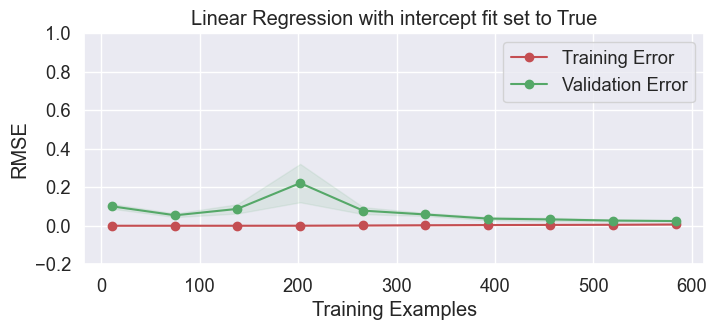

<Figure size 640x480 with 0 Axes>

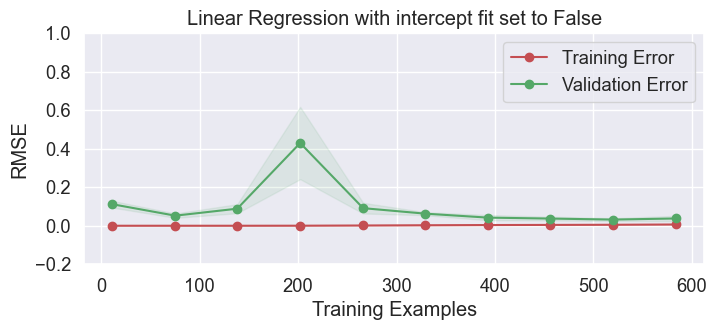

In [21]:
for i in [True,False]:
    plot_learning_curve(LinearRegression(fit_intercept = i),5,"Linear Regression with intercept fit set to" +" " + str(i));

<Figure size 640x480 with 0 Axes>

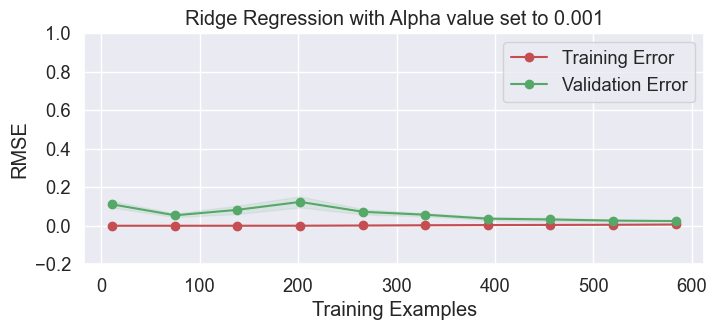

<Figure size 640x480 with 0 Axes>

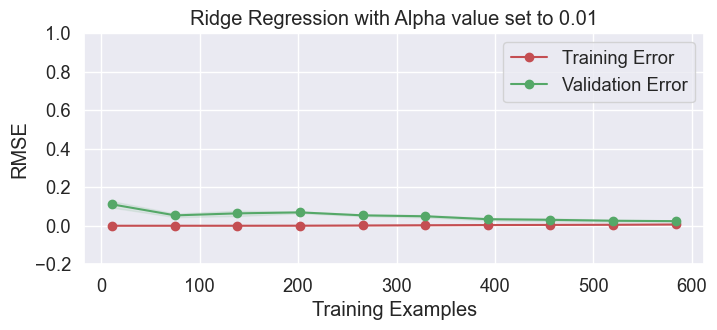

<Figure size 640x480 with 0 Axes>

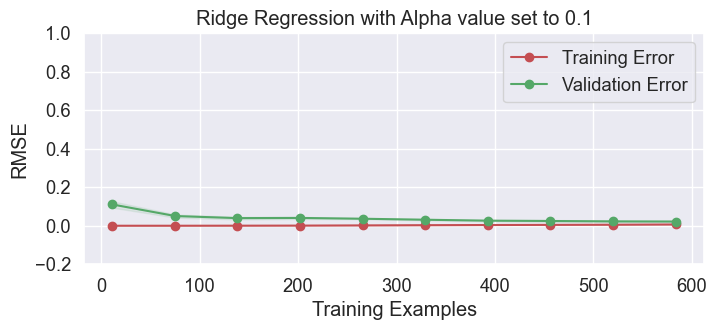

<Figure size 640x480 with 0 Axes>

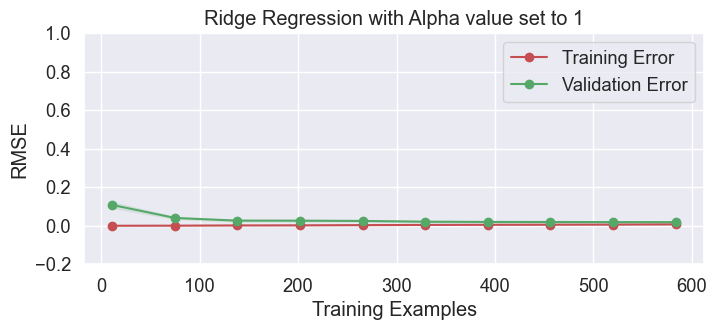

<Figure size 640x480 with 0 Axes>

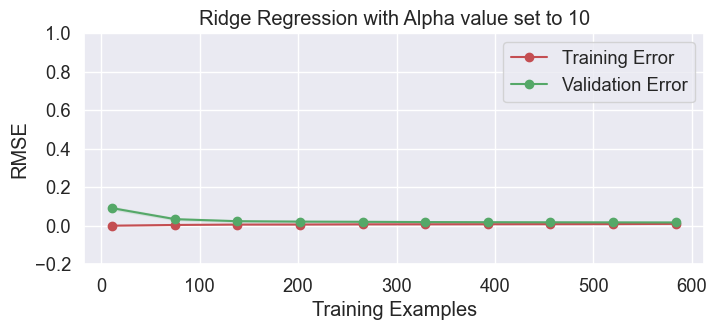

<Figure size 640x480 with 0 Axes>

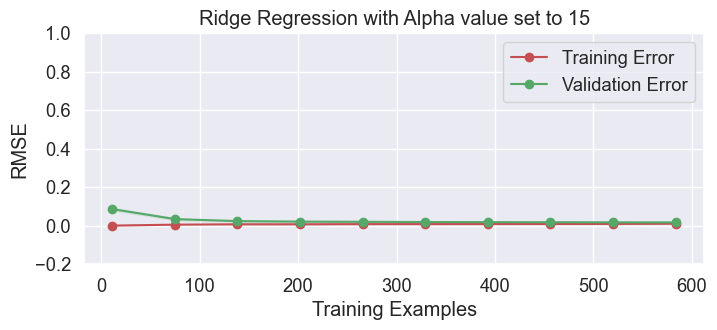

<Figure size 640x480 with 0 Axes>

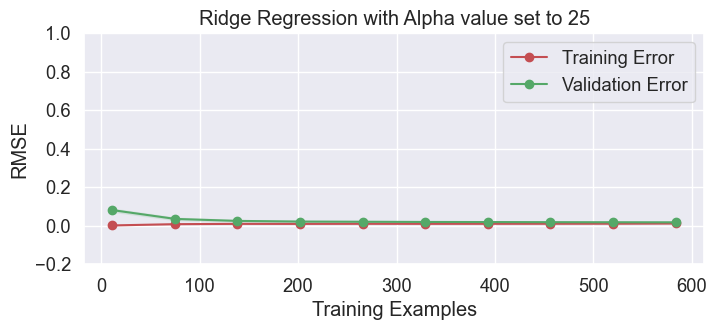

<Figure size 640x480 with 0 Axes>

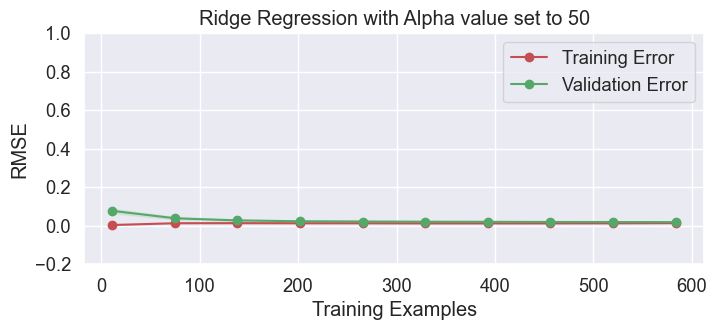

In [22]:
for i in parameter_range:
    plot_learning_curve(Ridge(alpha = i),5,"Ridge Regression with Alpha value set to" + " " + str(i))

<Figure size 640x480 with 0 Axes>

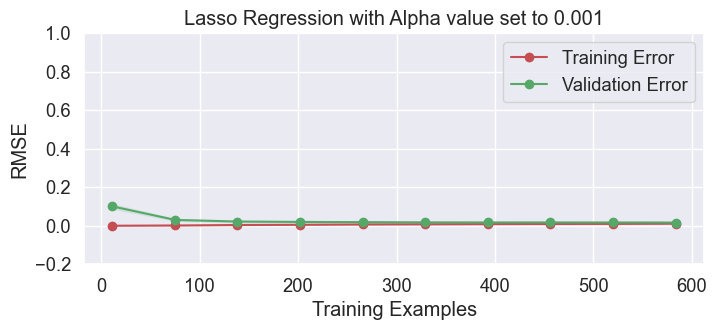

<Figure size 640x480 with 0 Axes>

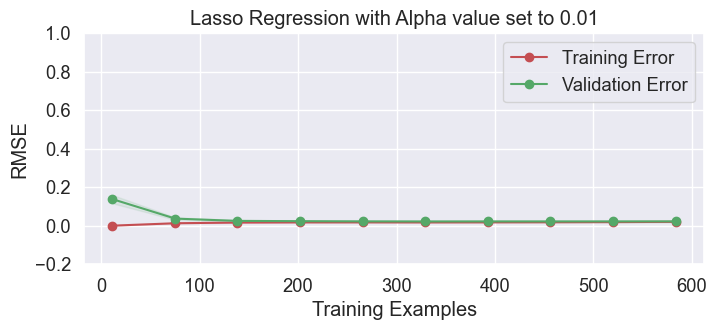

<Figure size 640x480 with 0 Axes>

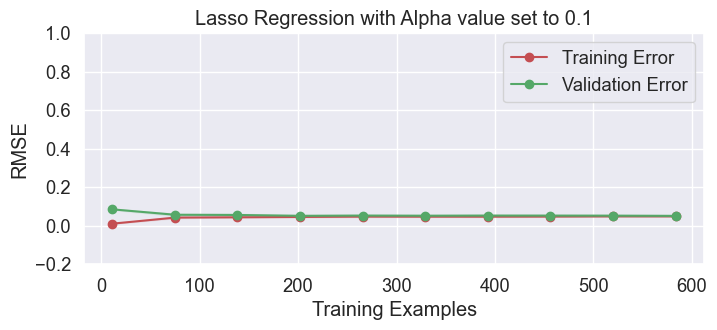

<Figure size 640x480 with 0 Axes>

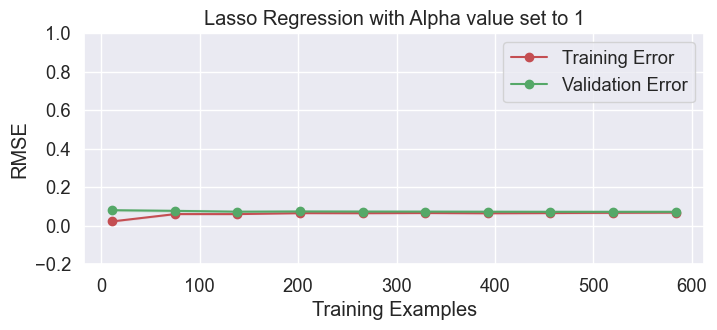

<Figure size 640x480 with 0 Axes>

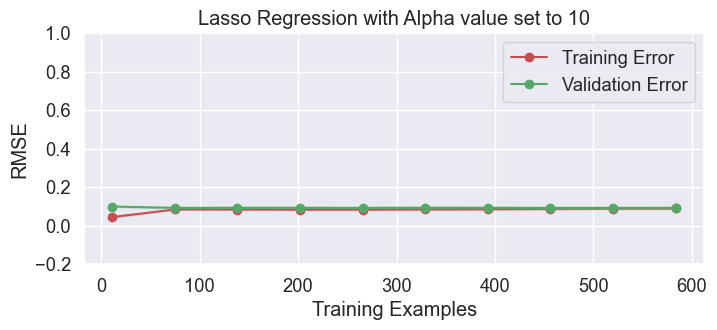

<Figure size 640x480 with 0 Axes>

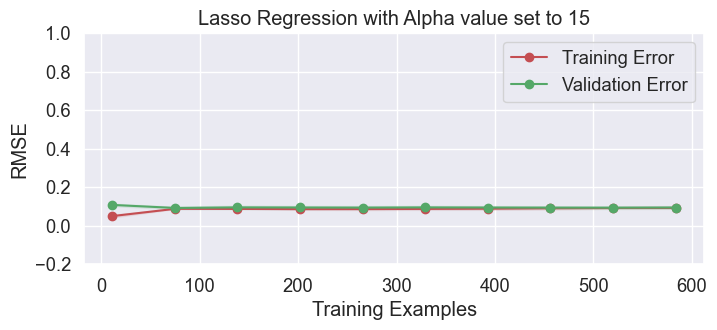

<Figure size 640x480 with 0 Axes>

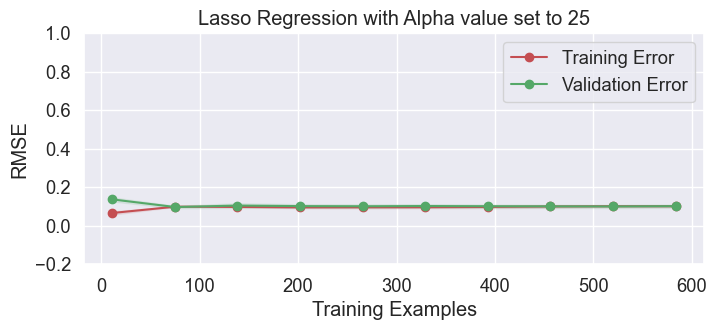

<Figure size 640x480 with 0 Axes>

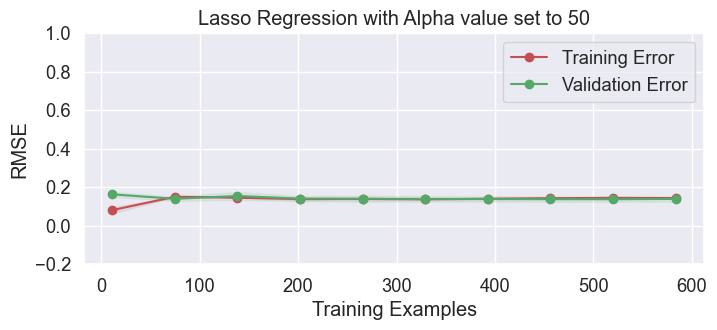

In [23]:
for i in parameter_range:
    plot_learning_curve(Lasso(alpha = i),5,"Lasso Regression with Alpha value set to" + " " + str(i))

The graphs clearly show the optimal hyperparameters for the linear model by comparing RMSE values. It can be seen that by setting the "fit intercept" hyperparameter to true, the RMSE value is just above 0.2, while setting it to False raises it to just under 0.4, therefore the optimal value is true. With Ridge and Lasso regression, its easy to spot the differences between various alpha values, but it is difficult to see exactly which of the alpha values is the optimal one. It can be seen that by increasing the alpha values, the validation RMSE becomes closer and closer to that of its training counterpart. However, to find the exact optimal value, GridSearch, a function which searches through a specified set of hyperparameter combinations to find the best combination that yields the highest model performance, had to be implemented. The code for this implementation is found below:

#### Train Models Using Optimal Hyperparameters

In [24]:
def best_hyperparameters(ModelType, parameters, X_train,t_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    regression_model = ModelType
    grid_search = GridSearchCV(regression_model, parameters, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, t_train)
    return grid_search.best_estimator_

optimal_linear_model = best_hyperparameters(LinearRegression(),linear_hyperparameters,X_train,t_train)
optimal_ridge_model = best_hyperparameters(Ridge(),ridge_hyperparameters,X_train,t_train)
optimal_lasso_model = best_hyperparameters(Lasso(),lasso_hyperparameters,X_train,t_train)

### 4. Results

Each of the models have been trained on the training dataset using their optimal hyperparameter values and have been tested below using the validation dataset. The training and validation regression scores have been generated for each model, as well as the RMSE of the predicted values.

In [25]:
def model_accuracy(Model, X_train, t_train, X_val,title):
    predicted_price = Model.predict(X_val)
    R2_train = Model.score(X_train,t_train)
    R2_val = Model.score(X_val,t_val)
    print("Training regression score = " + str(R2_train))
    print("Validation regression score = " + str(R2_val))
    MSE = mean_squared_error(t_val, predicted_price)
    RMSE = np.sqrt(MSE)
    print("The RMSE of the prediction = " + str(RMSE))
    sns.regplot(t_val,predicted_price);
    plt.title(title)
    plt.xlabel('Log transform of actual price')
    plt.ylabel('Log transform of predicted price')
    return

Training regression score = 0.9403252833561287
Validation regression score = 0.8714487539229651
The RMSE of the prediction = 0.15586690583111038


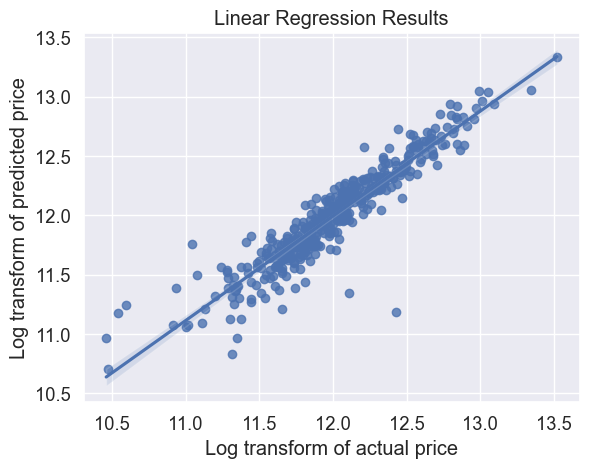

In [26]:
model_accuracy(optimal_linear_model,X_train,t_train,X_val,"Linear Regression Results")

Training regression score = 0.9261118816731816
Validation regression score = 0.8942040776385595
The RMSE of the prediction = 0.14140026826784208


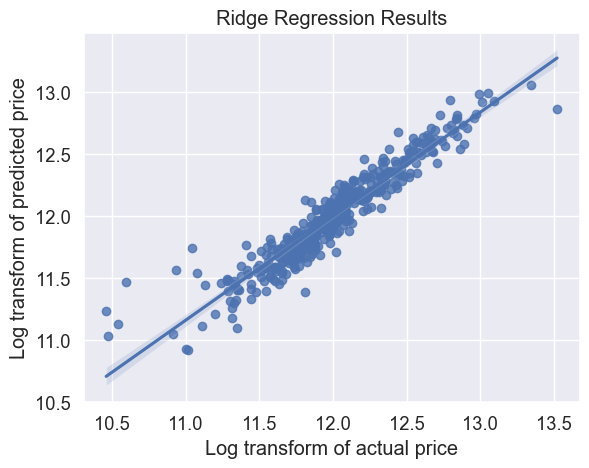

In [27]:
model_accuracy(optimal_ridge_model,X_train,t_train,X_val,"Ridge Regression Results")

Training regression score = 0.9160108683096683
Validation regression score = 0.8993562480110858
The RMSE of the prediction = 0.13791426150372427


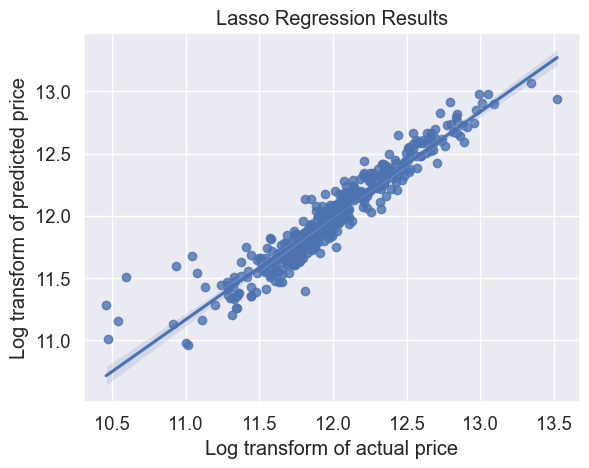

In [28]:
model_accuracy(optimal_lasso_model,X_train,t_train,X_val,"Lasso Regression Results")

#### Discussion of Results

Based on the observed graphs and numerical values, it is apparent that the performance of all three models is relatively similar. Based on the training regression scores, the Linear regression model has the best performance; however, it has the lowest validation regression score and highest RMSE. This result indicates that overfitting has occured, which is when a model fits too closely to the training data and thus performs worse when presented with unseen data. The high complexity of the dataset most likely causes this overfitting. To improve the performance of the Linear model, a greater number of features need to be removed using more advanced feature selection algorithms.

The Ridge regression model performs better than the Linear model due to its ability to reduce the weighting of undesirable variables and thus reduce the overfitting of the model.

The Lasso regression model performed the best with an RMSE value of 0.1379. The Lasso regression performs best because it is well-suited to handle datasets with a large amount of multicollinearity. Multicollinearity is when two variables in a dataset are highly correlated, and this can be seen with multiple variables, such as the relationship between "GarageCars" and "GarageArea." Lasso regression handles multicollinearity by altering the weighting of different variables and can thus effectively remove variables from the model that display undesirable qualities.  

### 5. Competition Submissions and Leaderboard Position

In [29]:
test_preds = np.expm1(optimal_lasso_model.predict(test))
test_data = pd.read_csv("test.csv")
submission = pd.DataFrame(test_preds, columns = ['SalePrice'])
ID = test_data[['Id']]
project_submission = pd.concat([ID, submission], axis=1)
project_submission.to_csv("project_submission.csv", index = False)

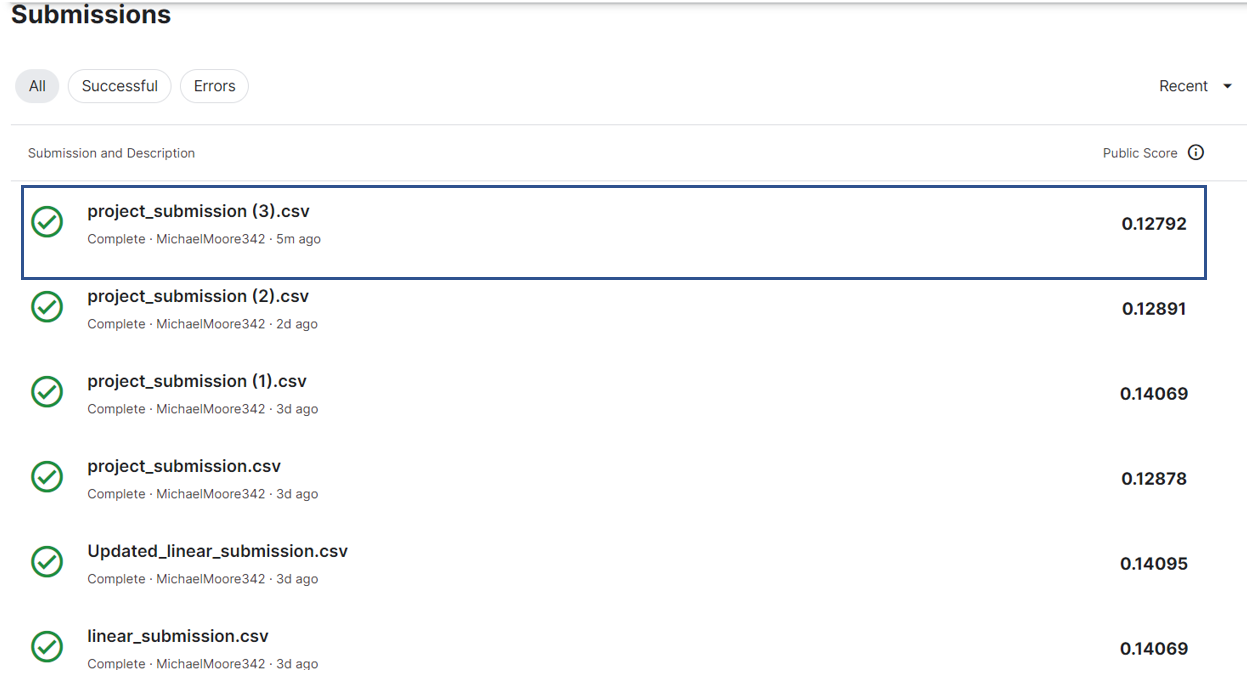

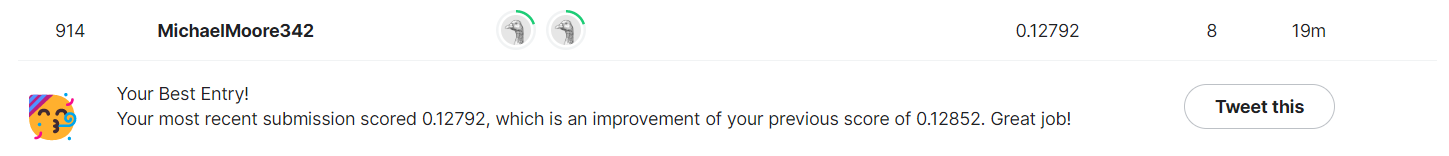

### 6. Summary

Three different machine-learning models were trained to predict house prices in Ames, Iowa, using various variables. Before the training of models could take place, the data was investigated to understand the effect of different variables on house prices and determine the relationships between these features. After analysing both the target and feature variables, it was concluded that most of the data were positively skewed, resulting in a greater number of outliers. A log transform was applied to the data to reduce these outliers and normalize the distributions of the dataset. Analysis of the categorical variables revealed specific features that provided little meaningful data due to them being the same for most houses. These variables were removed to decrease the computational complexity without impacting the potential model accuracy. The models selected to predict the house prices were Linear, Ridge, and Lasso regression. Experiments were conducted to determine the optimal number of features to use and the best hyperparameters to set for each model. Comparisons between the models revealed that Lasso regression had the best performance, while Linear regression suffered from overfitting the training data. The higher performance of the Lasso model can be attributed to its ability to reduce the multicollinearity, a prominent characteristic of this dataset.

### References

[1][Alexandru Papiu]. ([2023]). [Regularized Linear Models], [26] https://www.kaggle.com/code/apapiu/regularized-linear-models

[2][Aqx]. ([2021]). [Data Science Workflow TOP 2% (with Tuning)], [39] https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning/notebook

[3][Pedro Marcelino]. ([2022]). [Comprehensive data exploration with Python], [80] https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook

[4] 	M. Banoula, “Machine Learning Steps: A Complete Guide!,” 16 02 2023. [Online]. Available: https://www.simplilearn.com/tutorials/machine-learning-tutorial/machine-learning-steps. [Accessed 15 04 2023].

[5] 	S. Glen, “Lasso Regression: Simple Definition,” [Online]. Available: https://www.statisticshowto.com/lasso-regression/. [Accessed 15 04 2023].

[6] 	J. Brownlee, “How to Develop Ridge Regression Models in Python,” 11 10 2020. [Online]. Available: https://machinelearningmastery.com/ridge-regression-with-python/. [Accessed 18 04 2023].

[7] 	A. Biswal, “Sklearn Linear Regression,” 03 04 2023. [Online]. Available: https://www.simplilearn.com/tutorials/scikit-learn-tutorial/sklearn-linear-regression-with-examples. [Accessed 18 04 2023].

[8] 	K. S. Htoon, “Log Transformation: Purpose and Interpretation,” 29 02 2020. [Online]. Available: https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9. [Accessed 22 04 2023].

[9] 	I. Ismiguzel, “Imputing Missing Data with Simple and Advanced Techniques,” 12 05 2022. [Online]. Available: https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87. [Accessed 22 04 2023].

[10] 	R. Pramoditha, “Encoding Categorical Variables: One-hot vs Dummy Encoding,” 16 12 2021. [Online]. Available: https://towardsdatascience.com/encoding-categorical-variables-one-hot-vs-dummy-encoding-6d5b9c46e2db. [Accessed 21 04 2023].

[11] 	K. Nyuytiymbiy, “Parameters and Hyperparameters in Machine Learning and Deep Learning,” 30 12 2020. [Online]. Available: https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac. [Accessed 01 05 2023].